In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
def perform_adf_test(series):
    results = adfuller(series)
    print(f'ADF Statistic: {results[0]}')
    print(f'p-value: {results[1]}')

### Original Series

In [4]:
ts = pd.read_csv(r'C:\code\time_series\notebooks\data\original_series.csv')
ts.index = np.arange(1,len(ts)+1)
ts

,0
1,956.438486
2,7284.907174
3,11357.870166
4,13622.652007
5,17137.455304
...,...
68,42204.338905
69,42368.641039
70,42564.988401
71,42606.297399


Text(0, 0.5, 'Views')

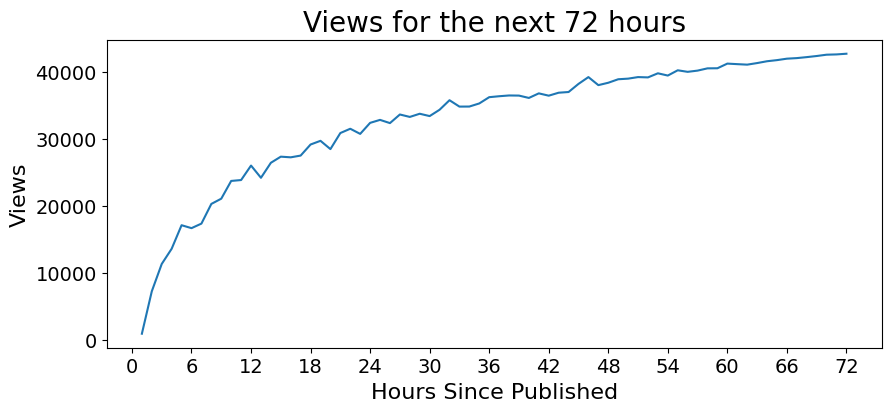

In [9]:
plt.figure(figsize=(10,4))
plt.plot(ts)
plt.title('Views for the next 72 hours',fontsize = 20)
plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

# Original Series: $v_t$

### (1) Normalize ($v_t \rightarrow n_t$): $n_t = \frac{v_t - \mu}{\sigma}$

### (2) Exponentiate ($n_t \rightarrow e_t$): $e_t = e^{n_t}$

### (3) First Difference ($e_t \rightarrow d_t$): $d_t = e_t - e_{t-1}$

### $d_t = e^{\frac{v_t - \mu}{\sigma}} - e^{\frac{v_{t-1} - \mu}{\sigma}}$

# --------------------------------------------

### (1) Normalize

Values of views too large, normalize so that they are more manageable

In [17]:
mu = np.mean(ts)
sigma = np.std(ts) # taking population std without bessel's correction, same as StandardScaler()

norm_ts = (ts - mu) / sigma

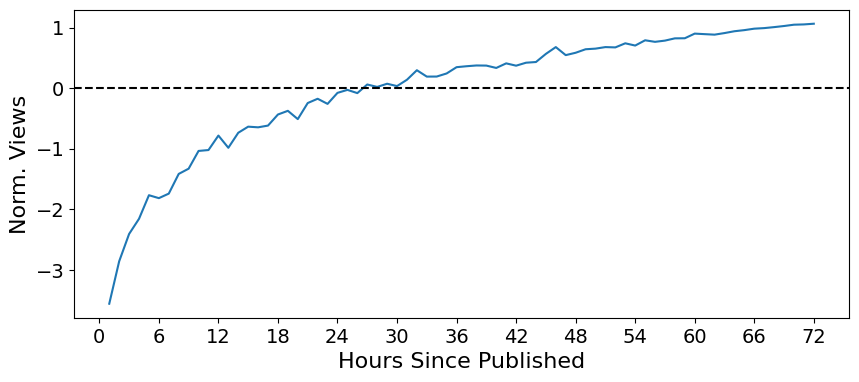

In [18]:
plt.figure(figsize=(10,4))
plt.plot(norm_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-3,2), fontsize=14)
plt.ylabel('Norm. Views', fontsize=16)

plt.axhline(0, color='k', linestyle='--')

### (2) Exponentiate

To straighten our expoential looking curve to more of a linear shape

In [19]:
exp_ts = np.exp(norm_ts)

Text(0, 0.5, 'Exp. Norm. Views')

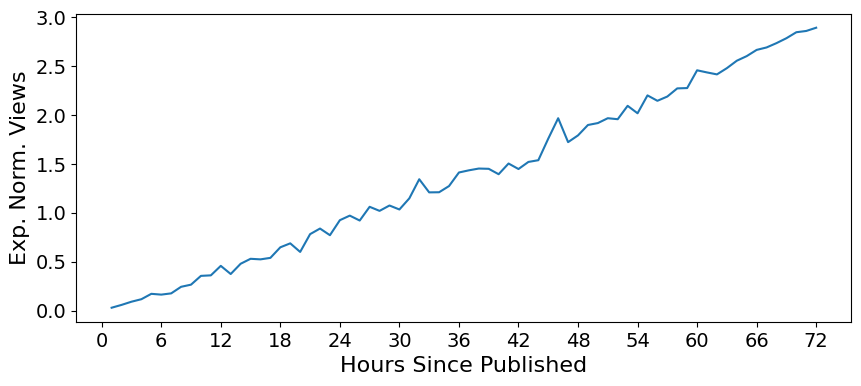

In [20]:
plt.figure(figsize=(10,4))
plt.plot(exp_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,3.5,.5), fontsize=14)
plt.ylabel('Exp. Norm. Views', fontsize=16)

In [21]:
perform_adf_test(exp_ts)

ADF Statistic: 1.6489790933114705
p-value: 0.9979973254868247


p-value >> 0.05, fail to reject $H_0$: that T.S contains unit root(non-stationary), meaning $H_0$ holds true and exp_ts is non-stationary

### (3) First Difference

In [22]:
diff_ts = exp_ts.diff().dropna()


Text(0, 0.5, 'First Diff. \nExp. Norm. Views')

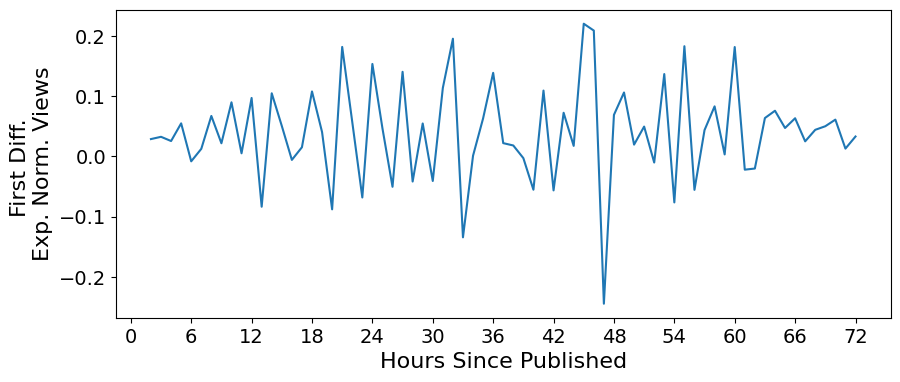

In [23]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

In [24]:
perform_adf_test(diff_ts)

ADF Statistic: -4.881063501302522
p-value: 3.795828400840156e-05


p-value << 0.05, we have strong evidence to reject $H_0$: T.S contains unit root and is non-stationary.             
We have successfully converted our T.S to a stationary one

### Model Selection

##### Check ACF and PACF Plot:
- ACF exponential decay indicates AR process
- PACF exponential decay incidates MA process
- Cutoffs after Lag X indicates order of process; PACF for AR, ACF for MA

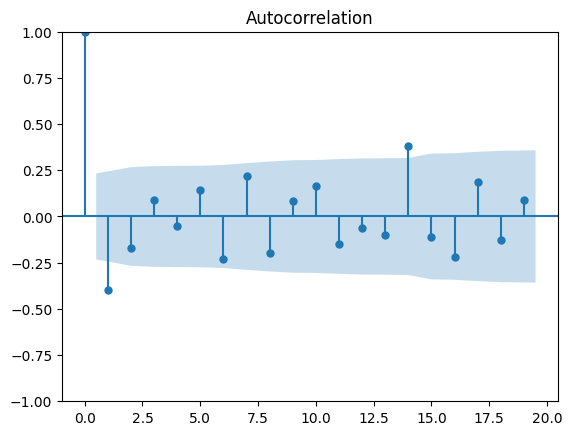

In [28]:
plot_acf(diff_ts)
plt.show()

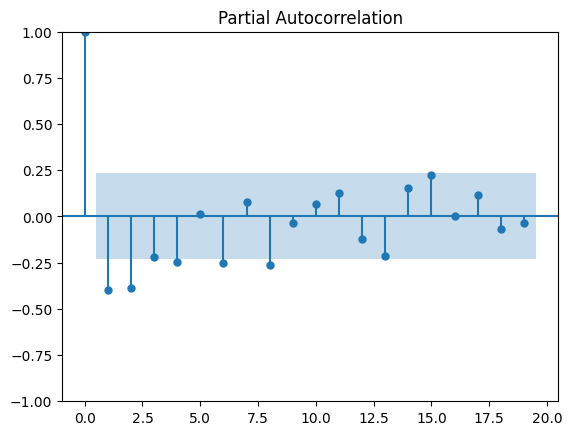

In [27]:
plot_pacf(diff_ts)
plt.show()

Both plots exhibit exponential decay indicating ARMA model

In [45]:
#create the model
model = ARIMA(diff_ts, order=(4,0,1))

c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [46]:
model_fit = model.fit()

### Predict Out 3 Hours

In [47]:
diff_ts

,0
2,0.028884
3,0.032666
4,0.025646
5,0.055005
6,-0.008073
...,...
68,0.044267
69,0.050217
70,0.061221
71,0.013050


In [50]:
prediction = model_fit.forecast(3)

# predictions = prediction_info[0]
# lower_bound = prediction_info[2][:,0]
# upper_bound = prediction_info[2][:,1]

c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\code\time_series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


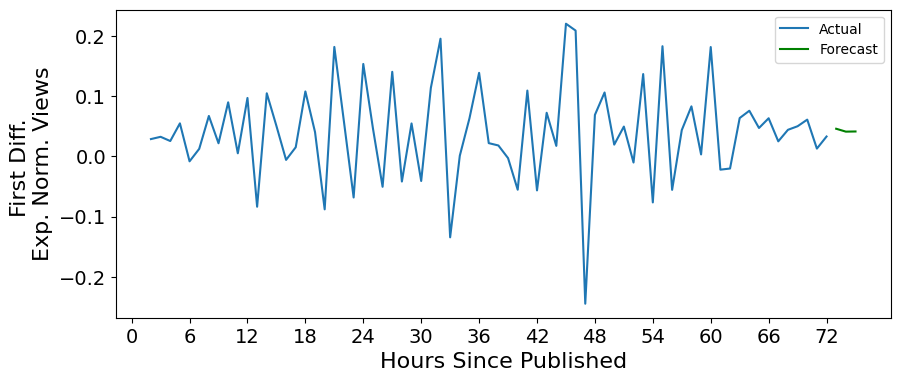

In [54]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), prediction, color='g')
plt.legend(['Actual','Forecast'], fontsize=10)


## Undo Transformations: ($\hat{d}_{t+1} \rightarrow \hat{v}_{t+1}$)

### $\hat{v}_{t+1} = \sigma \ln(\hat{d}_{t+1} + e^{\frac{v_t - \mu}{\sigma}}) + \mu$

For $\hat{v}_{t+2}$ we will need $v_{t+1}$ of the original series. Since we do not have $v_{t+1}$, instead we will be using our first prediction $\hat{v}_{t+1}$ in the calculation of $\hat{v}_{t+2}$

In [66]:
def undo_transformations(predictions, series, mu, sigma):
    first_pred = sigma*np.log(prediction.iloc[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_predictions = [first_pred]

    for i in range(len(prediction[1:])): # using pred v_{t+1} 
        next_pred = sigma*np.log(prediction.iloc[i+1] + np.exp((orig_predictions[-1]-mu)/sigma)) + mu
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [67]:
orig_preds = undo_transformations(prediction, ts, mu, sigma)

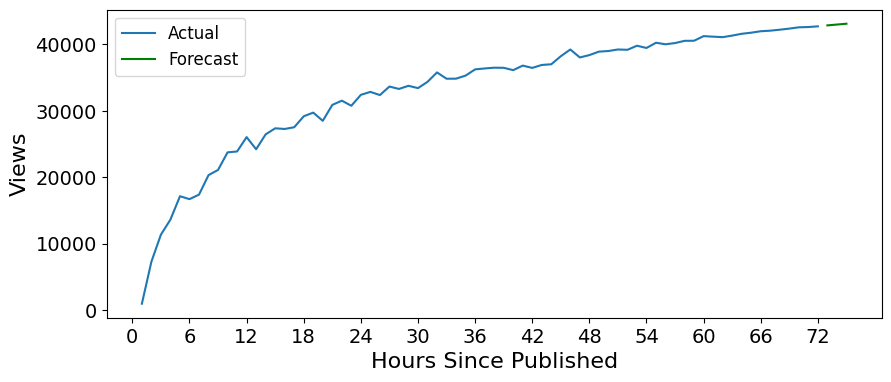

In [71]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.legend(['Actual','Forecast'], fontsize=12)

(40000.0, 45000.0)

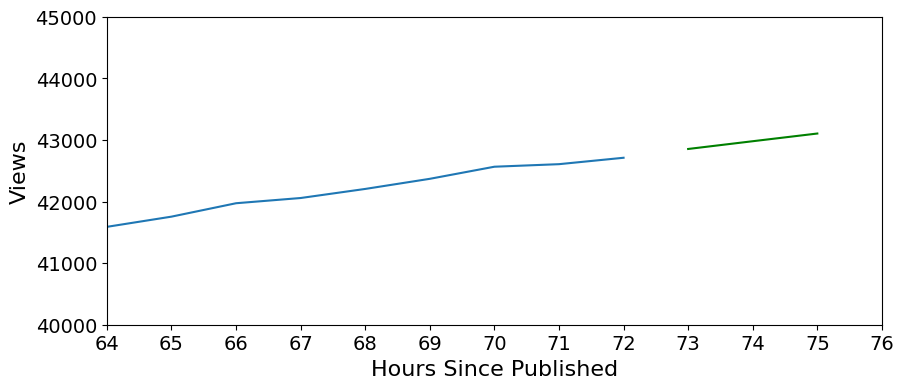

In [72]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(40000,46000,1000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.xlim(64,76)
plt.ylim(40000, 45000)

In [4]:
import yfinance as yf
tickerSymbol = 'PLTR'
tickerData = yf.Ticker(tickerSymbol)
tickerDF = tickerData.history(period='1d', start='2024-10-28', end='2024-11-1')
tickerDF

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-28 00:00:00-04:00,45.049999,45.139999,44.680000,44.970001,36729700,0.0,0.0
2024-10-29 00:00:00-04:00,44.900002,45.070000,44.040001,44.930000,26154700,0.0,0.0
2024-10-30 00:00:00-04:00,44.580002,44.799999,43.610001,43.689999,31309200,0.0,0.0
2024-10-31 00:00:00-04:00,42.790001,43.320000,40.900002,41.560001,50973400,0.0,0.0


In [6]:
tickerDF.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [8]:
for col in tickerDF.columns:
    tickerDF[col] = tickerDF[col].round(3)
tickerDF

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-28 00:00:00-04:00,45.05,45.14,44.68,44.97,36729700,0.0,0.0
2024-10-29 00:00:00-04:00,44.90,45.07,44.04,44.93,26154700,0.0,0.0
2024-10-30 00:00:00-04:00,44.58,44.80,43.61,43.69,31309200,0.0,0.0
2024-10-31 00:00:00-04:00,42.79,43.32,40.90,41.56,50973400,0.0,0.0
